# Integrate 3rd party transforms into a MONAI program

This tutorial shows how to integrate 3rd party transforms into a MONAI program.  
Mainly showing transforms from `BatchGenerator`, `TorchIO`, `Rising` and `ITK`.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/MONAI/blob/master/examples/notebooks/integrate_3rd_party_transforms.ipynb)

## Setup environment

In [1]:
%pip install -qU "monai[gdown]"

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -qU matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -q batchgenerators==0.20.1

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install -q itk==5.1.0

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install -q rising==0.2.0

Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install -q torchio==0.17.21

Note: you may need to restart the kernel to use updated packages.


## Setup imports

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import glob
import os
import shutil
import tempfile

import batchgenerators
import itk
import matplotlib.pyplot as plt
import numpy as np
import rising.random
import rising.transforms
import torchio

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadNiftid,
    Orientationd,
    ScaleIntensityRanged,
    Spacingd,
    SqueezeDimd,
    ToTensord,
    adaptor,
)
from monai.utils import first, set_determinism

print_config()

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [8]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/data/medical


## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [9]:
resource = "https://drive.google.com/uc?id=1jzeNU1EKnK81PyTsrx0ujfNl-t0Jo8uE"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Set MSD Spleen dataset path

In [10]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

## Set deterministic training for reproducibility

In [11]:
set_determinism(seed=0)

## Setup MONAI transforms

In [12]:
monai_transforms = [
    LoadNiftid(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image", "label"], source_key="image"),
]

## Setup BatchGenerator transforms

Note:
1. BatchGenerator requires the arg is `**data`, can't compose with MONAI transforms directly, need `adaptor`.
1. BatchGenerator requires data shape is [B, C, H, W, D], MONAI requires [C, H, W, D].

In [13]:
batch_generator_transforms = batchgenerators.transforms.color_transforms.ContrastAugmentationTransform(
    data_key="image"
)

## Setup TorchIO transforms

Note:
1. The TorchIO transforms can support MONAI dict input data directly.
1. It can handle PyTorch Tensor data(shape: [C, H, W, D]), so used it to handle Tensor in this tutorial.

In [14]:
torchio_transforms = torchio.transforms.RescaleIntensity(
    out_min_max=(0.0, 1.0), percentiles=(0.05, 99.5), keys=["image"]
)

## Setup Rising transforms

Note:
1. Rising inherits from PyTorch `nn.Module`, expected input data type is PyTorch Tensor, so can only work after `ToTensor`.
1. Rising requires data shape is [B, C, H, W, D], MONAI requires [C, H, W, D].
1. Rising requires the arg is `**data`, need `adaptor`.

In [15]:
rising_transforms = rising.transforms.Mirror(
    dims=rising.random.DiscreteParameter((0, 1, 2)), keys=["image", "label"]
)

## Setup ITK transforms

Note:
1. ITK transform function API has several args(not only `data`), need to set args in wrapper before Compose.
1. If input data is Numpy, ITK can't support dict type, need wrapper to convert the format.
1. ITK expects input shape [H, W, [D]], so handle every channel and stack the results.

In [16]:
def itk_transforms(x):
    smoothed = list()
    for channel in x["image"]:
        smoothed.append(itk.median_image_filter(channel, radius=2))
    x["image"] = np.stack(smoothed)
    return x

## Compose all transforms

In [17]:
transform = Compose(
    monai_transforms
    + [
        itk_transforms,
        # add another dim as BatchGenerator and Rising expects shape [B, C, H, W, D]
        AddChanneld(keys=["image", "label"]),
        adaptor(batch_generator_transforms, {"image": "image"}),
        ToTensord(keys=["image", "label"]),
        adaptor(rising_transforms, {"image": "image", "label": "label"}),
        # squeeze shape from [B, C, H, W, D] to [C, H, W, D] for TorchIO transforms
        SqueezeDimd(keys=["image", "label"], dim=0),
        torchio_transforms,
    ]
)

## Check transforms in DataLoader

image shape: torch.Size([329, 282, 136]), label shape: torch.Size([329, 282, 136])


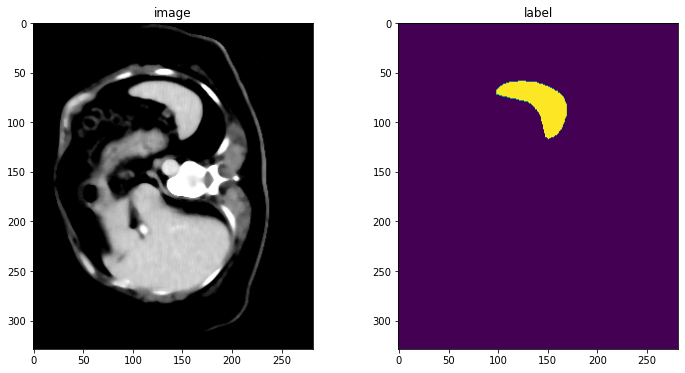

In [18]:
check_ds = Dataset(data=data_dicts, transform=transform)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [19]:
if directory is None:
    shutil.rmtree(root_dir)